In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download mohammedhamdy98/water-potability

In [ ]:
! unzip drinking-water-quality-distributionmonitoring.zip

In [17]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# Loading in libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

from collections import Counter

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [19]:

df = pd.read_csv("/content/water_potability.csv")

In [20]:
df.shape

(3276, 10)

In [21]:
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


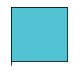

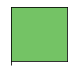

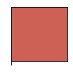

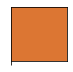

In [23]:
# Kode warna
blue = '#51C4D3' # air minum
green = '#74C365' # air tak bisa diminum 
red = '#CD6155' # perlu di analisis
orange = '#DC7633' # perlu di analisis

# Plot the colors as a palplot
sns.palplot([blue])
sns.palplot([green])
sns.palplot([red])
sns.palplot([orange])

 Biru akan menampilkan air yang dapat diminum, . Warna hijau keruh akan digunakan dalam air yang tidak aman untuk dikonsumsi.

In [24]:
# Menghitung jumlah setiap kolom
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

A 1 berarti air dapat diminum, 0 berarti air tidak dapat diminum. Plot menunjukkan, bahwa sebagian besar sampel dalam kumpulan data tidak dapat diminum. perlu mempertimbangkan ini saat membuat model.

In [26]:
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

<Figure size 432x288 with 0 Axes>

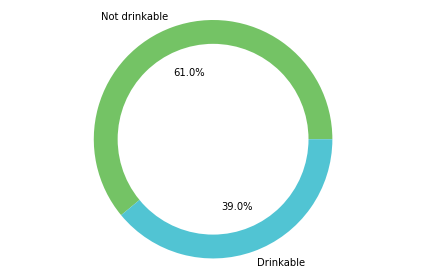

In [27]:

plt.clf()
plt.style.use('ggplot')

# Create subplot and pie chart
fig1, ax1 = plt.subplots()
ax1.pie(df['Potability'].value_counts(), colors=[green, blue], labels=['Not drinkable', 'Drinkable'], autopct='%1.1f%%', startangle=0, rotatelabels=False)

#draw circle
centre_circle = plt.Circle((0,0),0.80, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [28]:
# menentukan daftar fitur yang akan diplot
feature = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

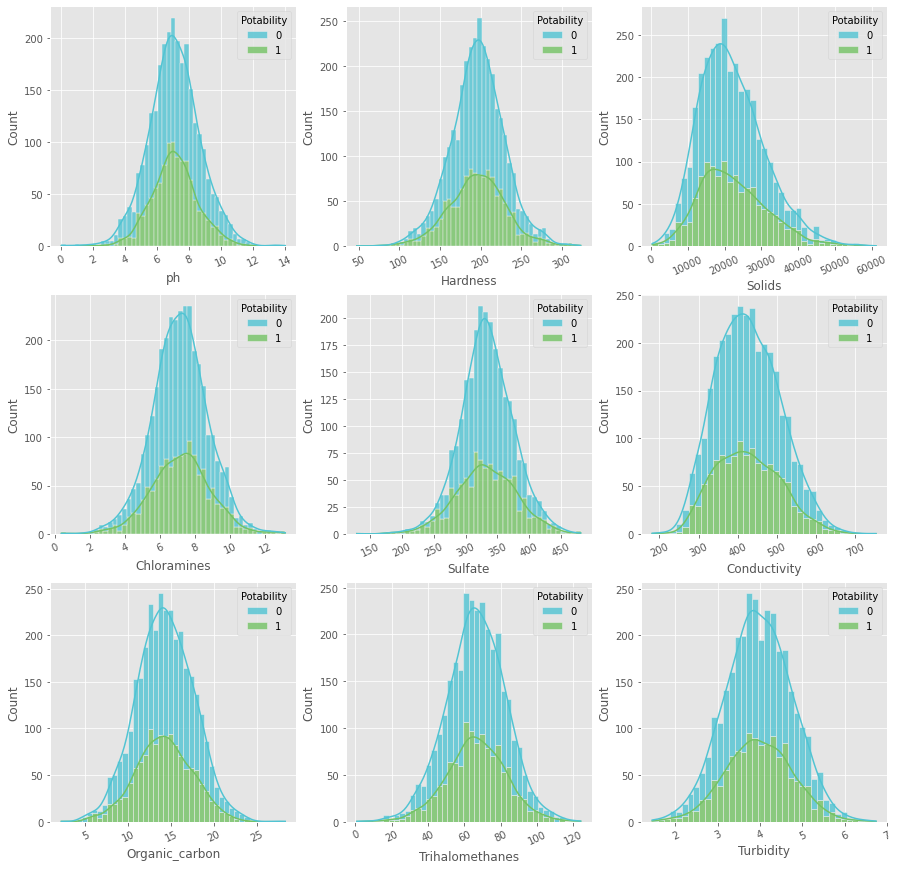

In [29]:
# Drop Potability column
plotter_dataset = df.drop('Potability', axis=1)

plt.figure(figsize = (15, 15))
for i in enumerate(feature):
    plt.subplot(3, 3,i[0]+1)

    # plotting the fetures in the dataset
    sns.histplot(
        data = plotter_dataset, 
        x = plotter_dataset[i[1]], 
        hue = df['Potability'], 
        palette= [blue, green], 
        kde = True, 
        multiple='stack', 
        alpha=0.8
    )

    
    plt.xticks(rotation = 25)

# **Filtering Data**

In [30]:
# Define a plotting function
def mask_plotter(column, mask1, mask2, label1, label2, color2, title):
    # Set size and stlye
    plt.figure(figsize=(5, 5))
    plt.style.use('ggplot')

    # Create to histplots
    sns.histplot(data=df[mask1], x=column, multiple='stack', color=blue, label=label1) # Save
    sns.histplot(data=df[mask2], x=column, multiple='stack', color=color2, label=label2)

    # Add title, legend and show plot
    plt.title(title)
    plt.legend()
    plt.show()

In [31]:
# Create masks to filter ph-values 
drinkable_ph_mask = (df['ph'] > 6.5) & (df['ph'] < 9)
undrinkable_ph_mask = (df['ph'] < 6.5) | (df['ph'] > 9)

 
soft_mask = (df['Hardness'] < 150)
hard_mask = (df['Hardness'] > 150) 


eu_recommendation = (df['Sulfate'] < 250) 
who_recommendation = (df['Sulfate'] > 250) & (df['Sulfate'] < 500)

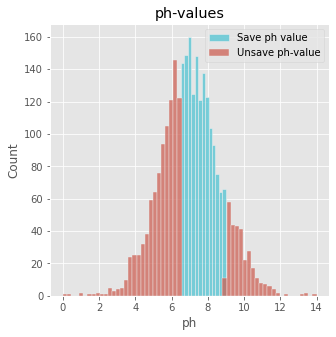

In [32]:
# Plot ph-values
mask_plotter('ph', drinkable_ph_mask, undrinkable_ph_mask, 'Save ph value', 'Unsave ph-value', red, 'ph-values')

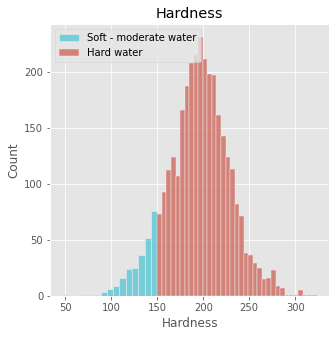

In [33]:
# Plot Hardness 
mask_plotter('Hardness', soft_mask, hard_mask, 'Soft - moderate water', 'Hard water', red, 'Hardness')

Segala sesuatu di atas 150 mg/L dianggap sebagai air "keras". Sebagian besar sampel termasuk dalam kategori itu. Namun, air sadah tidak selalu buruk.

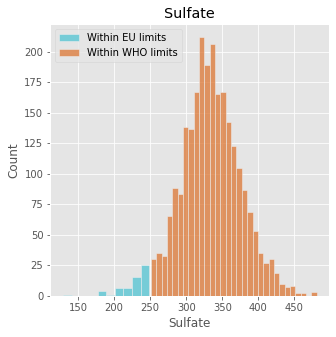

In [34]:
# Plot Sulfate
mask_plotter('Sulfate', eu_recommendation, who_recommendation, 'Within EU limits', 'Within WHO limits', orange, 'Sulfate')

semua yang di bawah 250 mg/L Sulfat sebagai aman, sebagian besar sampel tidak akan dianggap Dapat Diminum. Namun WHO akan melihat semua sampel baik-baik saja, karena mereka menetapkan batas pada 500 mg/L.

# **Data preparation**

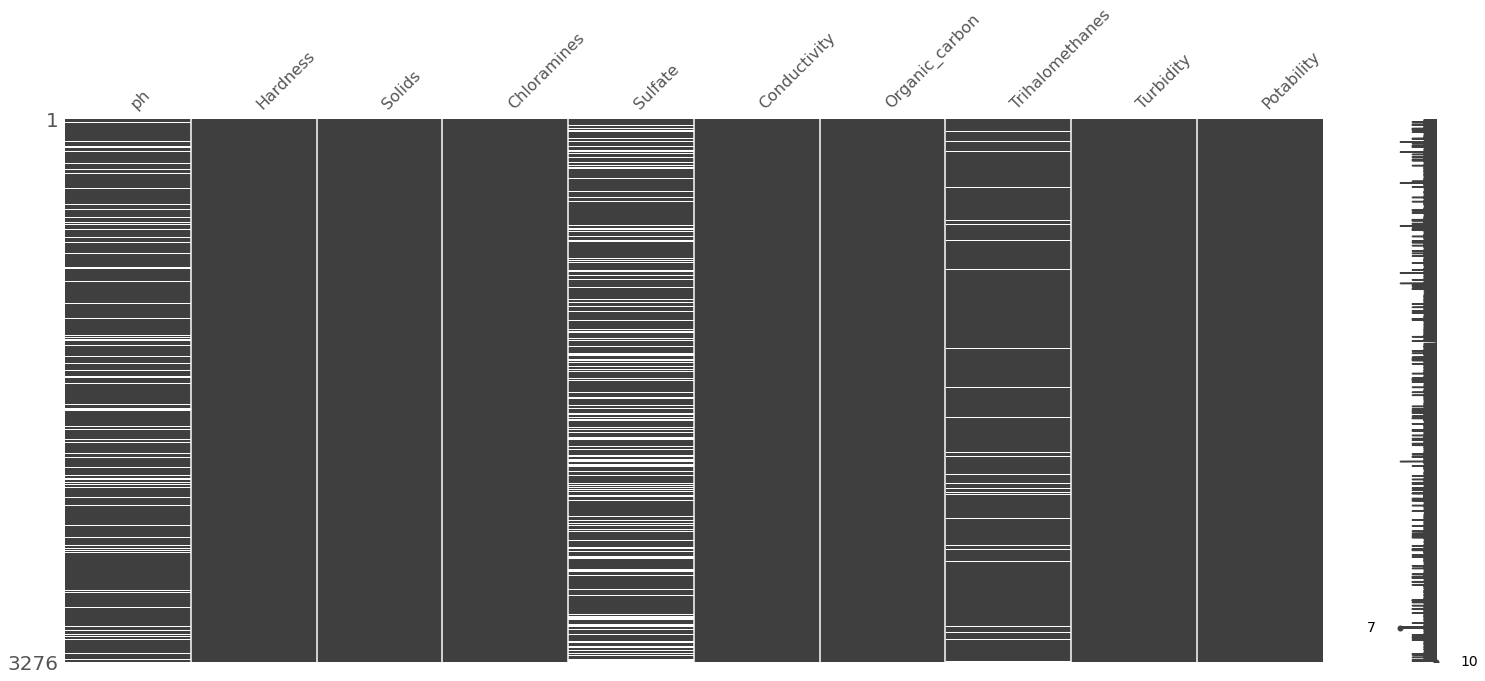

In [36]:
# Plot out missing values
fig = msno.matrix(df)

Nilai yang hilang akan diganti dengan nilai median.

In [38]:
# Mean and median of ph
print("Mean of ph: " + str(df['ph'].mean()))
print("Median of ph: " + str(df['ph'].median()))
print('-------------------------------------------')

# Mean and median of Sulfates
print("Mean of Sulfate: " + str(df['Sulfate'].mean()))
print("Median of Sulfate: " + str(df['Sulfate'].median()))
print('-------------------------------------------')

# Mean and median of Trihalomethanes
print("Mean of Trihalomethanes: " + str(df['Trihalomethanes'].mean()))
print("Median of Trihalomethanes: " + str(df['Trihalomethanes'].median()))
print('-------------------------------------------')

Mean of ph: 7.080794504276835
Median of ph: 7.036752103833548
-------------------------------------------
Mean of Sulfate: 333.7757766108135
Median of Sulfate: 333.073545745888
-------------------------------------------
Mean of Trihalomethanes: 66.39629294676803
Median of Trihalomethanes: 66.62248509808484
-------------------------------------------


In [39]:
# Replacing nan values with the median
df['ph'].fillna(value=df['ph'].median(),inplace=True)
df['Sulfate'].fillna(value=df['Sulfate'].median(),inplace=True)
df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median(),inplace=True)

In [41]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

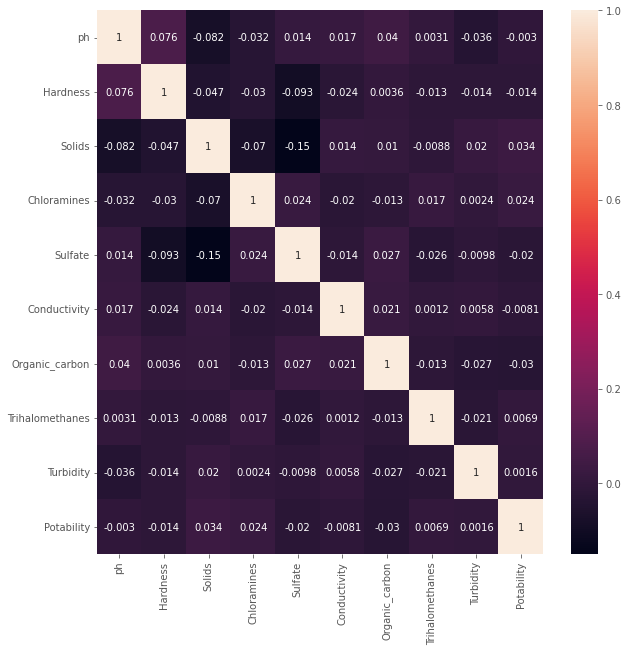

In [42]:
# CEK KORELASI

# Set figure size
plt.figure(figsize=(10, 10))

# Create heatmap
sns.heatmap(df.corr(), annot=True)

# Show plot
plt.show()

In [44]:
# Setting features (X) and targets(y)
X = df.drop('Potability', axis=1)
y = df['Potability']

In [45]:
# Split data into training and testing dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale the data. Only training data is fitted, testing data is only transformed
# Selain itu, hanya nilai x yang diskalakan, karena y hanya berisi nilai 0 dan 1, yang tidak ingin kita skalakan
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

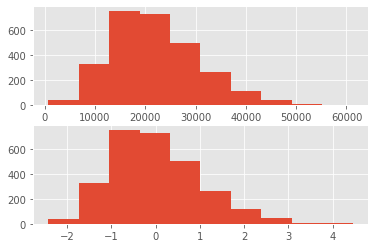

In [46]:
# Creatre figure and list containing axes
fig, ax = plt.subplots(2, 1)

# Plot histogram of before and after scaling
X_train.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(X_train_scaled[:, 2])
plt.show()

In [47]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
xgb = GradientBoostingClassifier()
knn = KNeighborsClassifier()

In [48]:
# lr param grid
lr_params = {
    'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0, 5, 10)}

# Instantiate cross validated logistic regression random search 
rs_lr = RandomizedSearchCV(estimator=lr, param_distributions=lr_params, cv=5)

# Fit lr to trainig data
rs_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:811: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1.0 / C, sample_weight),
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:122: RuntimeWarning: invalid value encountered in double_scalars
  out = -np.sum(sample_weight * log_logistic(yz)) + 0.5 * alpha * np.dot(w, w)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:127: RuntimeWarning: invalid value encountered in multiply
  grad[:n_features] = safe_sparse_dot(X.T, z0) + alpha * w
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:811: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1.0 / C, sample_weight),
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:122: RuntimeWarning: invalid value encountered in double_scalars
  out = -np.sum(sample_weight * log_logistic(yz)) + 0.5 * alpha * np.dot(w, w)
/usr/loca

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ]),
                                        'penalty': ['l1', 'l2']})

In [49]:
# rfc param grid
rfc_params = {   
    'n_estimators' : [*range(25, 400, 20)],
    'criterion' : ['gini', 'entropy'],
    'max_depth': [*range(1, 11)],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4]}

# Instantiate cross validated random forest random search
rs_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_params, cv=5)

# Fit rfc to trainig data
rs_rfc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [25, 45, 65, 85, 105,
                                                         125, 145, 165, 185,
                                                         205, 225, 245, 265,
                                                         285, 305, 325, 345,
                                                         365, 385]})

In [50]:
# dtc param grid
dtc_params = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth': [*range(1, 11)],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4]}

# Instantiate cross validated desicion tree random search 
rs_dtc = RandomizedSearchCV(estimator=dtc, param_distributions=dtc_params, cv=5)

# Fit dtc to trainig data
rs_dtc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'splitter': ['best', 'random']})

In [51]:
# xgb param grid
xgb_params = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : np.linspace(0, 1, 10),
    'n_estimators' : [*range(25, 500, 10)]}

# Instantiate cross validated extreme gradient boosting random search 
rs_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, cv=5)

# Fit xgb to training data 
rs_xgb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 275, in _check_params
    "learning_rate must be greater than 0 but was %r" % self.learning_rate
ValueError: learning_rate must

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'loss': ['deviance', 'exponential'],
                                        'n_estimators': [25, 35, 45, 55, 65, 75,
                                                         85, 95, 105, 115, 125,
                                                         135, 145, 155, 165,
                                                         175, 185, 195, 205,
                                                         215, 225, 235, 245,
                                                         255, 265, 275, 285,
                                                         295, 305, 315, ...]})

In [52]:
# knn param grid
knn_params = {
    'n_neighbors' : [*range(1, 11)],
    'weights' : ['uniform', 'distant'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree' 'brute'],
    'leaf_size' : [10, 20, 30, 40]}

# Instantiate cross validated k-nearest neighbor random search 
rs_knn = RandomizedSearchCV(estimator=knn, param_distributions=knn_params, cv=5)

# Fit knn to training data 
rs_knn.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 196, in fit
    self.weights = _check_weights(self.weights)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 83, in _check_weights
    "weights not recognized: should be 'uniform', "
ValueError: 

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_treebrute'],
                                        'leaf_size': [10, 20, 30, 40],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10],
                                        'weights': ['uniform', 'distant']})

# **Selecting Model**

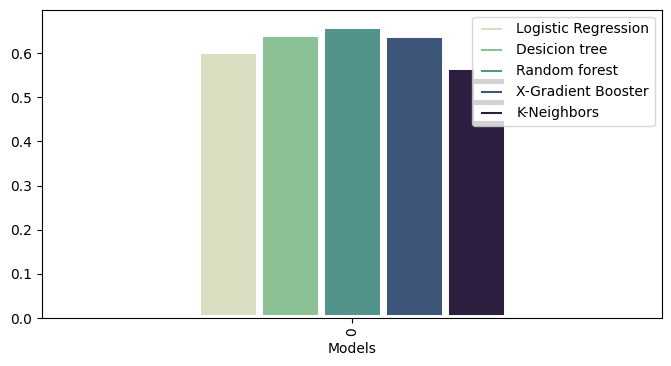

In [53]:
# Set up all models scores as a df
score_df =  pd.DataFrame({'Logistic Regression' :  [rs_lr.best_score_] ,'Desicion tree' : [rs_dtc.best_score_], \
'Random forest' : [rs_rfc.best_score_],'X-Gradient Booster': [rs_xgb.best_score_] ,'K-Neighbors' : [rs_knn.best_score_]})

# Plot bar plot
plt.style.use('default')
color_palette = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
score_df.plot(kind='bar', edgecolor='white', colormap=color_palette, linewidth=5, figsize=(8, 4), xlabel='Models')

# Show plot
plt.show()

In [54]:
# Te Best Model


from sklearn.metrics import accuracy_score

# Set up the best classifiert
rfc_v02 = RandomForestClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=6, n_estimators=265)

# Train it 
rfc_v02.fit(X_train, y_train)

# Predict on unseen data
y_pred = rfc_v02.predict(X_test)

# Get the score of the model
print('Correct Prediction (%): ', accuracy_score(y_test, y_pred, normalize = True) * 100.0)

Correct Prediction (%):  65.04065040650406


**Feature importances**

<Figure size 640x480 with 0 Axes>

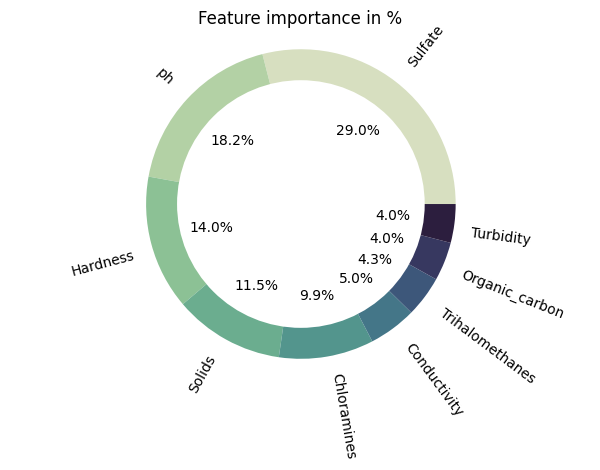

In [55]:
# Get feature importance
feature_imp = pd.Series(rfc_v02.feature_importances_, index=X.columns).sort_values(ascending=False)

# Clear matplotlib
plt.clf()

# Create subplot and pie chart
fig1, ax1 = plt.subplots()
ax1.pie(feature_imp, colors=sns.cubehelix_palette(start=.5, rot=-.75, n_colors=9), labels=feature_imp.index, autopct='%1.1f%%', startangle=0, rotatelabels=True)

#draw circle
centre_circle = plt.Circle((0,0),0.80, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

# Set tighten layout and show plot 
plt.title('Feature importance in %')
plt.tight_layout()
plt.show()